In [35]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mutual_info_score

def get_alpha_data(ticker, freq, api_key):
    """
    Downloads historical data for a given ticker using Alpha Vantage.
    freq: '1d' for daily, '1wk' for weekly, '1mo' for monthly.
    Returns a DataFrame with datetime index and a 'close' column.
    """
    ts = TimeSeries(key=api_key, output_format='pandas')
    if freq == '1d':
        data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
    elif freq == '1wk':
        data, meta_data = ts.get_weekly(symbol=ticker)
    elif freq == '1mo':
        data, meta_data = ts.get_monthly(symbol=ticker)
    else:
        raise ValueError("Frequency not recognized. Use '1d', '1wk', or '1mo'.")
        
    # The returned DataFrame has columns like '1. open', '2. high', etc.
    # We use the '4. close' column as the close price.
    data = data.rename(columns={'4. close': 'close'})
    # Convert the index to datetime if not already
    data.index = pd.to_datetime(data.index)
    # Sort the index ascending
    data = data.sort_index()
    return data[['close']]

def compute_binary_mutual_info_alpha(ticker1, ticker2, window_months=6, freq='1d', api_key=None):
    """
    Downloads data for ticker1 and ticker2 from Alpha Vantage, filters data for the last window_months,
    computes percentage returns, binarizes the returns (1 for positive, -1 for negative),
    and computes mutual information using mutual_info_score.
    """
    if api_key is None:
        raise ValueError("Please provide a valid Alpha Vantage API key.")
    
    end_date = datetime.today()
    start_date = end_date - pd.DateOffset(months=window_months)
    
    # Download data for each ticker
    data1 = get_alpha_data(ticker1, freq, api_key)
    data2 = get_alpha_data(ticker2, freq, api_key)
    
    # Merge on date
    df = pd.merge(data1, data2, left_index=True, right_index=True, how='inner', suffixes=(f'_{ticker1}', f'_{ticker2}'))
    # Filter the time window
    df = df[(df.index >= start_date) & (df.index <= end_date)]
    
    # Compute percentage returns
    df[f'return_{ticker1}'] = df[f'close_{ticker1}'].pct_change()
    df[f'return_{ticker2}'] = df[f'close_{ticker2}'].pct_change()
    df = df.dropna()
    
    # Binarize the returns: 1 if >0, else -1
    df[f'binary_{ticker1}'] = np.where(df[f'return_{ticker1}'] > 0, 1, -1)
    df[f'binary_{ticker2}'] = np.where(df[f'return_{ticker2}'] > 0, 1, -1)
    
    # Extract the binary series
    X = df[f'binary_{ticker1}']
    Y = df[f'binary_{ticker2}']
    
    # Compute mutual information using mutual_info_score (discrete estimator)
    mi = mutual_info_score(X, Y)
    print(f"Mutual Information (binary) between {ticker1} and {ticker2} over the last {window_months} months at {freq} frequency: {mi:.4f} nats")
    return mi

# Example usage: (replace 'YOUR_API_KEY' with your actual Alpha Vantage API key)
api_key = '9AAOBFYSRR9IE9JS'
compute_binary_mutual_info_alpha('ASML', 'TSM', window_months=3, freq='1d', api_key=api_key)


Mutual Information (binary) between ASML and TSM over the last 3 months at 1d frequency: 0.1414 nats


np.float64(0.14135801825327152)

In [22]:
from sklearn.feature_selection import mutual_info_regression

# Ensure that X is 2D: a DataFrame with one column
X = nvda.to_frame()  # or aapl.values.reshape(-1, 1)
y = aapl  # y can be a 1D array/Series

mi = mutual_info_regression(X, y, random_state=42)
print(mi[0])


0


<Axes: >

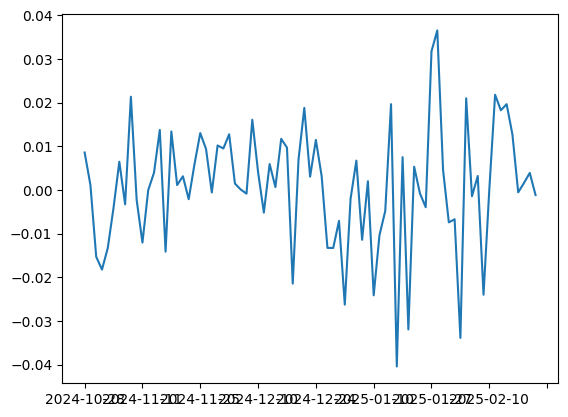

In [24]:
aapl.plot()

<Axes: >

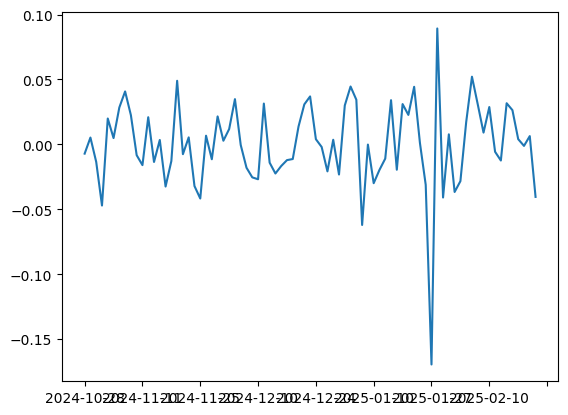

In [25]:
nvda.plot()

# Financtial health evaluation and intrinsic price based on Ana's formula

In [53]:
import requests
from dataclasses import dataclass
from typing import Optional

@dataclass
class QuantValues:
    ticker: str
    market_cap: float
    pe_ratio: float
    pb_ratio: float
    ev_ebitda: float
    enterprise_value: float
    earnings_yield: float
    sector: str
    industry: str
    intrinsic_value: Optional[float] = None  # Computed from DCF model (per share)
    current_price: Optional[float] = None  # Latest stock price

def get_financial_data(ticker: str, api_key: str) -> QuantValues:
    base_url = "https://www.alphavantage.co/query"

    # Fetch company overview
    overview_params = {"function": "OVERVIEW", "symbol": ticker, "apikey": api_key}
    overview_response = requests.get(base_url, params=overview_params).json()

    if "MarketCapitalization" not in overview_response:
        raise ValueError(f"Failed to retrieve data for {ticker}: {overview_response}")

    # Extract fundamental data
    market_cap = float(overview_response.get("MarketCapitalization", 0))
    pe_ratio = float(overview_response.get("PERatio", 0))
    pb_ratio = float(overview_response.get("PriceToBookRatio", 0))
    ev_ebitda = float(overview_response.get("EVToEBITDA", 0))
    sector = overview_response.get("Sector", "N/A")
    industry = overview_response.get("Industry", "N/A")

    # Fetch latest stock price
    price_params = {"function": "GLOBAL_QUOTE", "symbol": ticker, "apikey": api_key}
    price_response = requests.get(base_url, params=price_params).json()

    try:
        current_price = float(price_response["Global Quote"]["05. price"])
    except:
        current_price = None

    # Fetch balance sheet for debt and cash
    balance_sheet_params = {"function": "BALANCE_SHEET", "symbol": ticker, "apikey": api_key}
    balance_sheet_response = requests.get(base_url, params=balance_sheet_params).json()

    try:
        total_debt = float(balance_sheet_response["annualReports"][0]["shortLongTermDebtTotal"])
        cash_equivalents = float(balance_sheet_response["annualReports"][0]["cashAndCashEquivalentsAtCarryingValue"])
    except:
        total_debt = 0
        cash_equivalents = 0

    # Compute enterprise value manually
    enterprise_value = market_cap + total_debt - cash_equivalents

    # Fetch cash flow statement for free cash flow
    cashflow_params = {"function": "CASH_FLOW", "symbol": ticker, "apikey": api_key}
    cashflow_response = requests.get(base_url, params=cashflow_params).json()

    try:
        free_cash_flow = float(cashflow_response["annualReports"][0]["operatingCashflow"]) - \
                         float(cashflow_response["annualReports"][0]["capitalExpenditures"])
        shares_outstanding = float(overview_response.get("SharesOutstanding", market_cap / current_price))  # Estimate if missing
    except:
        free_cash_flow = None
        shares_outstanding = None

    # Compute intrinsic value using refined DCF model
    intrinsic_value = compute_dcf(
        free_cash_flow, enterprise_value, ev_ebitda, shares_outstanding
    ) if free_cash_flow and shares_outstanding else None

    return QuantValues(
        ticker=ticker,
        market_cap=market_cap,
        pe_ratio=pe_ratio,
        pb_ratio=pb_ratio,
        ev_ebitda=ev_ebitda,
        enterprise_value=enterprise_value,
        earnings_yield=1 / pe_ratio if pe_ratio else 0,
        sector=sector,
        industry=industry,
        intrinsic_value=intrinsic_value,
        current_price=current_price
    )

def compute_dcf(free_cash_flow: float, enterprise_value: float, ev_ebitda: float, shares_outstanding: float,
                discount_rate: float = 0.09, growth_rate: float = 0.04, years: int = 10):
    """
    Computes intrinsic value per share using a refined Discounted Cash Flow (DCF) model.
    - Uses a mix of perpetual growth and EV/EBITDA exit multiple for terminal value.
    """
    total_value = 0
    for year in range(1, years + 1):
        discounted_fcf = (free_cash_flow * (1 + growth_rate) ** year) / ((1 + discount_rate) ** year)
        total_value += discounted_fcf

    # Terminal Value Calculation (uses EV/EBITDA instead of pure perpetuity)
    terminal_value = (free_cash_flow * (1 + growth_rate) ** years) * ev_ebitda
    terminal_value /= (1 + discount_rate) ** years  # Discount to present value

    total_value += terminal_value

    # Convert to intrinsic value per share
    intrinsic_value_per_share = total_value / shares_outstanding

    return intrinsic_value_per_share

API_KEY = "9AAOBFYSRR9IE9JS"  # Replace with your actual Alpha Vantage API key
ticker = "AM"  # Example stock ticker
quant_values = get_financial_data(ticker, API_KEY)
print(quant_values)

ValueError: Failed to retrieve data for AM: {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}